

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.


##  assignment

Applying different supervised machine learning techniques to this data set, and see which one yields the highest accuracy by diferent methods:

* Decision tree
* Random forest
* K-Fold cross validation
* A Neural network using Keras.



## Let's begin: prepare the data

Start by importing the mammographic_masses.data.txt file into a Pandas dataframe 

In [411]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

feature_columns=['BI-RADS','Age','Shape','Margin','Density','Severity']
df = pd.read_csv('mammographic_masses.data.txt',na_values=['?'],names = feature_columns)


In [412]:
df.count()

BI-RADS     959
Age         956
Shape       930
Margin      913
Density     885
Severity    961
dtype: int64

## Data Cleaning for blank records and splitting for test and Train

In [413]:
df.dropna(inplace=True)
df.head()

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
8,5.0,57.0,1.0,5.0,3.0,1
10,5.0,76.0,1.0,4.0,3.0,1


In [414]:
all_features = df.drop('Severity', axis=1).values
all_classes = df['Severity'].values

# Normalize the Feature data

In [415]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)
all_features_scaled

array([[ 0.3211177 ,  0.7650629 ,  0.17563638,  1.39618483,  0.24046607],
       [ 0.3211177 ,  0.15127063,  0.98104077,  1.39618483,  0.24046607],
       [-0.20875843, -1.89470363, -1.43517241, -1.157718  ,  0.24046607],
       ...,
       [-0.20875843,  0.56046548,  0.98104077,  1.39618483,  0.24046607],
       [ 0.3211177 ,  0.69686376,  0.98104077,  1.39618483,  0.24046607],
       [-0.20875843,  0.42406719,  0.17563638,  0.11923341,  0.24046607]])

# Split the data for Train and test

In [416]:
X_train, X_test, y_train, y_test = train_test_split(all_features_scaled, all_classes, test_size=0.30)

# Now create a DecisionTreeClassifier and fit it to your training data. 
# Display the resulting decision tree.

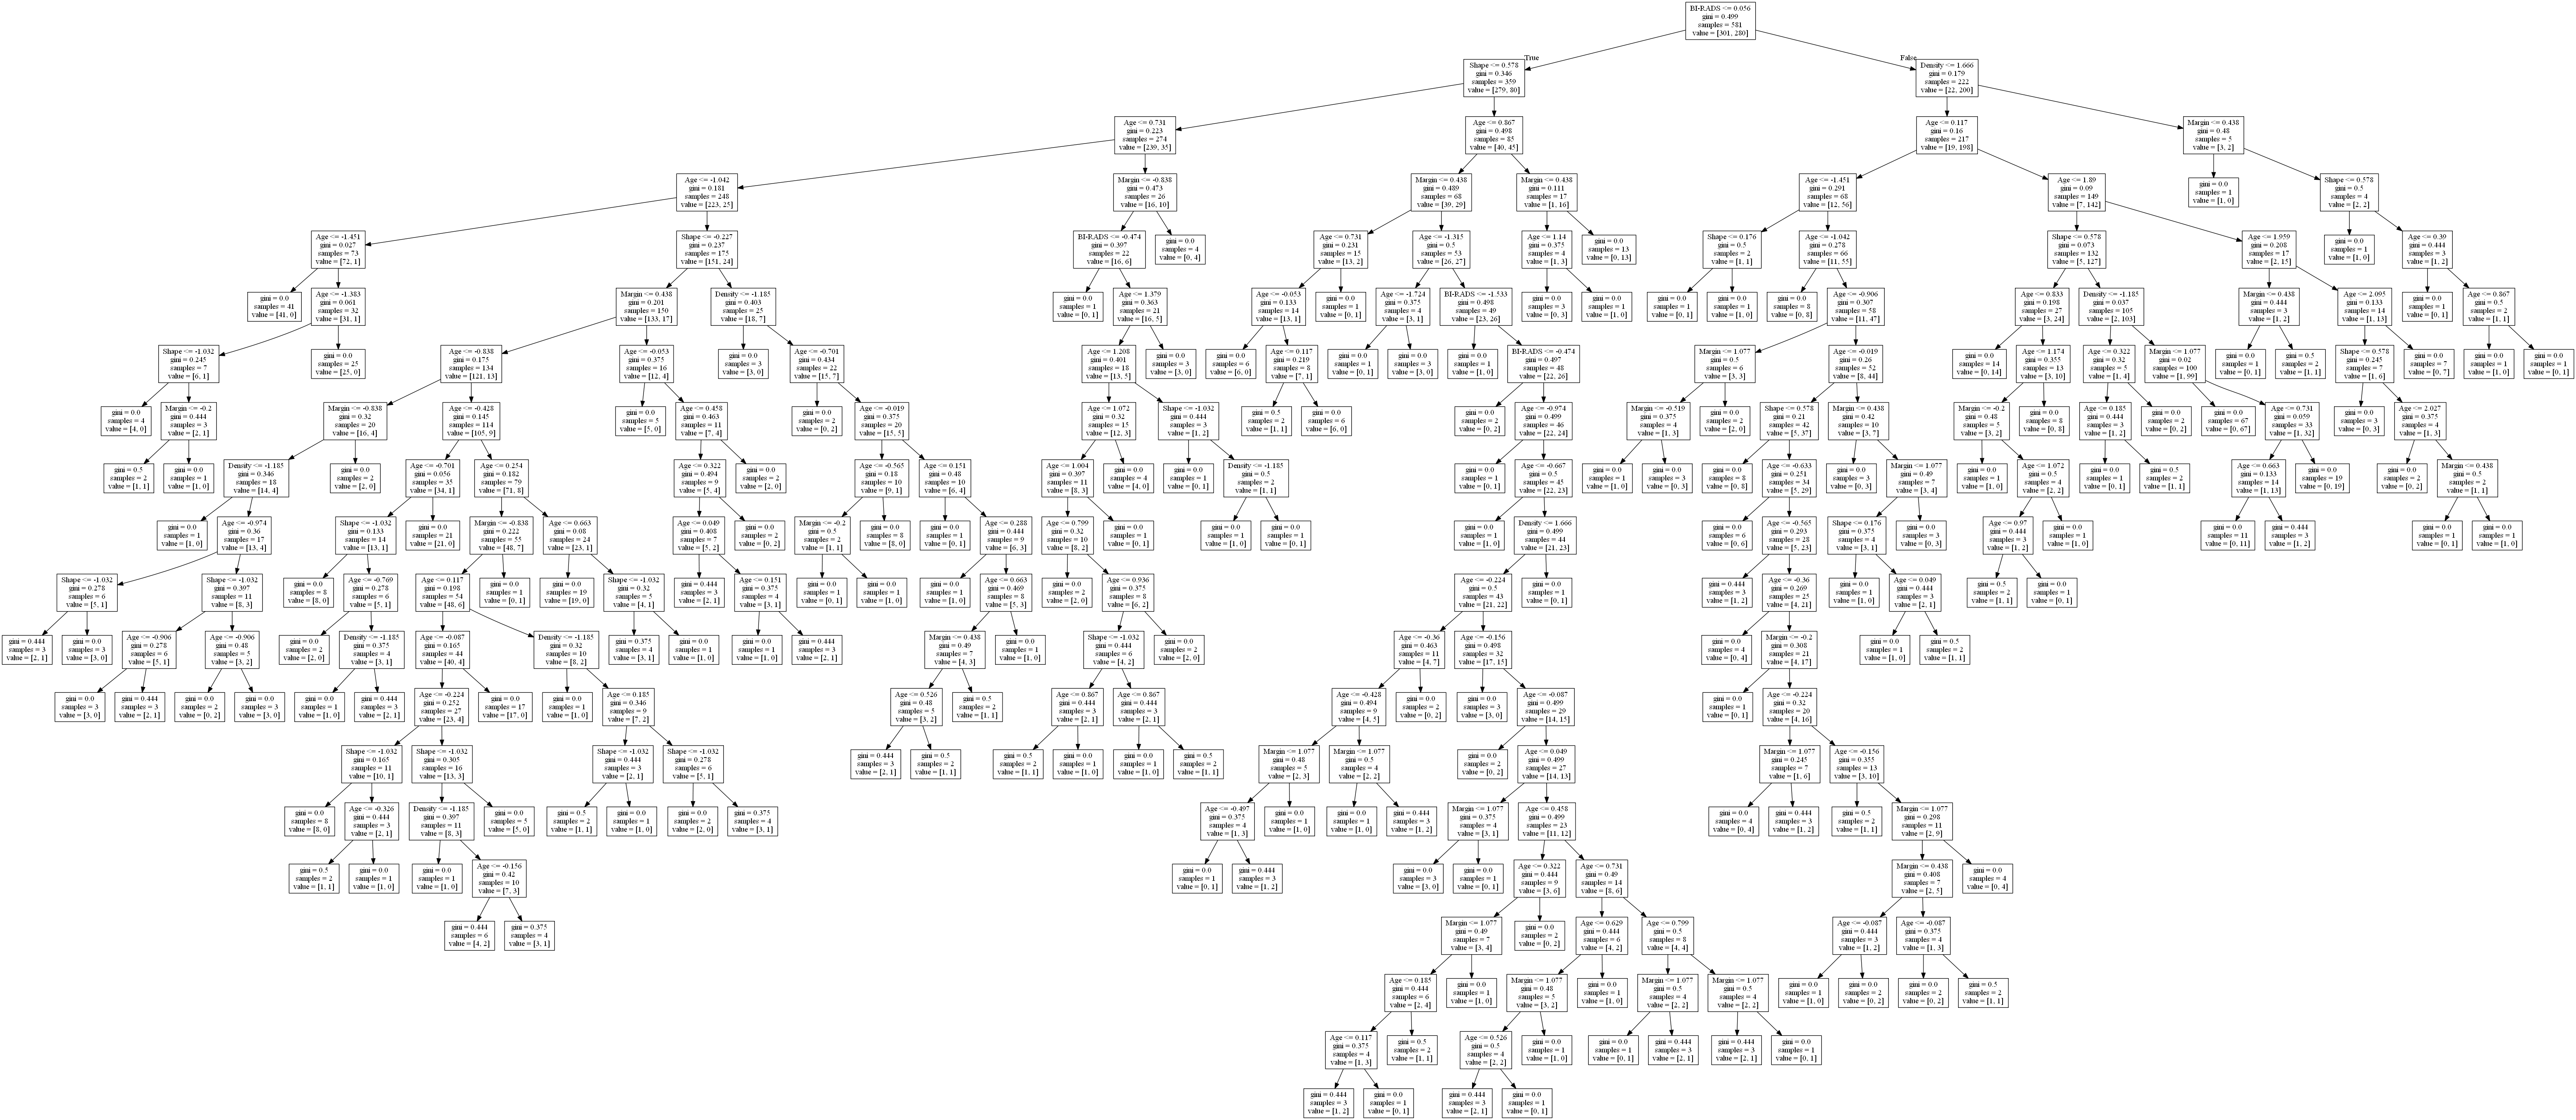

In [417]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydotplus as pyd
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
feature_cols=['BI-RADS','Age','Shape','Margin','Density']


dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=feature_cols)  
graph = pyd.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  


# Display the test data accuracy:

In [418]:
clf.score(X_test, y_test)

0.7590361445783133

## Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your model's accuracy (K=10)

In [419]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=1)

cv_scores = cross_val_score(clf, all_features_scaled, all_classes, cv=10)

cv_scores.mean()

0.7708475015042751

## Now try RandomForestClassifier...

In [420]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, random_state=1)
cv_scores = cross_val_score(clf, all_features_scaled, all_classes, cv=10)

cv_scores.mean()

0.7841435428123644

## Neural Networks



In [421]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential


model = Sequential()
#4 feature inputs going into an 6-unit layer (more does not seem to help - in fact you can go down to 4)
model.add(Dense(36, input_dim=5, kernel_initializer='normal', activation='relu'))
model.add(Dense(16, input_dim=5, kernel_initializer='normal', activation='relu'))
# "Deep learning" turns out to be unnecessary - this additional hidden layer doesn't help either.
#model.add(Dense(4, kernel_initializer='normal', activation='relu'))
# Output layer with a binary classification (benign or malignant)
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
# Compile model; adam seemed to work best
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=115, batch_size=20)
loss_and_metrics = model.evaluate(X_train, y_train,batch_size=500)
#loss_and_metrics


Epoch 1/115
581/581 [==============================] - 1s 2ms/sample - loss: 0.6891 - acc: 0.7143
Epoch 2/115
581/581 [==============================] - 0s 171us/sample - loss: 0.6673 - acc: 0.7986
Epoch 3/115
581/581 [==============================] - 0s 161us/sample - loss: 0.6061 - acc: 0.7986
Epoch 4/115
581/581 [==============================] - ETA: 0s - loss: 0.5512 - acc: 0.783 - 0s 165us/sample - loss: 0.5343 - acc: 0.7969
Epoch 5/115
581/581 [==============================] - 0s 226us/sample - loss: 0.4722 - acc: 0.8107
Epoch 6/115
581/581 [==============================] - 0s 221us/sample - loss: 0.4442 - acc: 0.8176s - loss: 0.4718 - acc: 0.80
Epoch 7/115
581/581 [==============================] - 0s 148us/sample - loss: 0.4329 - acc: 0.8141
Epoch 8/115
581/581 [==============================] - 0s 139us/sample - loss: 0.4262 - acc: 0.8107
Epoch 9/115
581/581 [==============================] - 0s 178us/sample - loss: 0.4237 - acc: 0.8107
Epoch 10/115
581/581 [==============

In [422]:
loss_and_metrics

[0.3610023707407887, 0.8502582]

In [423]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Wrap our Keras model in an estimator compatible with scikit_learn
estimator = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)
# Now we can use scikit_learn's cross_val_score to evaluate this model identically to the others
#cv_scores = cross_val_score(estimator, all_features_scaled, all_classes, cv=10)
#cv_scores = cross_val_score(estimator, cv=10)
#cv_scores.mean()


In [424]:
mse_value, mae_value = model.evaluate(X_test, y_test, verbose=0)

In [425]:
mse_value,mae_value

(0.3852646756603057, 0.83935744)

In [426]:
classes = model.predict(X_test, batch_size=128)
y_pred = model.predict(X_test)

In [427]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.5390846763219269

## For the model regression score  r2 ~1 is good model.

In [428]:
model = Sequential()
model.add(Dense(64, input_dim=5, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

In [429]:
model = Sequential()
model.add(Dense(128, input_dim=5, activation='sigmoid'))
model.add(Dense(1))

In [430]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
581/581 [==============================] - 1s 1ms/sample - loss: 1.1751 - acc: 0.6695
Epoch 2/100
581/581 [==============================] - 0s 149us/sample - loss: 0.5316 - acc: 0.7642
Epoch 3/100
581/581 [==============================] - 0s 90us/sample - loss: 0.5203 - acc: 0.7711
Epoch 4/100
581/581 [==============================] - 0s 160us/sample - loss: 0.5013 - acc: 0.7952
Epoch 5/100
581/581 [==============================] - 0s 151us/sample - loss: 0.4970 - acc: 0.7969
Epoch 6/100
581/581 [==============================] - 0s 102us/sample - loss: 0.5241 - acc: 0.8021
Epoch 7/100
581/581 [==============================] - 0s 106us/sample - loss: 0.5713 - acc: 0.7986
Epoch 8/100
581/581 [==============================] - 0s 164us/sample - loss: 0.5431 - acc: 0.7969
Epoch 9/100
581/581 [==============================] - 0s 151us/sample - loss: 0.5788 - acc: 0.7986
Epoch 10/100
581/581 [==============================] - 0s 124us/sample - loss: 0.5151 - acc: 0.8176
Ep

In [431]:
classes = model.predict(X_test, batch_size=128)
y_pred = model.predict(X_test)

In [434]:
r2_score(y_test, y_pred)

0.4814462370782323

## Conclusion: Overall Nueral Network giving better perfomance over any other models.
## However by adding additional  Nuerons there is no improvement in r2 score and acuracy also.   